In [26]:
import torch
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [28]:
ms2=load_dataset("allenai/mslr2022","ms2")
cochrane=load_dataset("allenai/mslr2022","cochrane")

In [29]:
cochrane_df=cochrane["train"].to_pandas()
ms2_df=ms2["train"].to_pandas()
all_datasets=[cochrane_df,ms2_df]

In [30]:
ms2_df.drop(columns=['background','review_id','pmid'],inplace=True)
cochrane_df.drop(columns=['review_id','pmid'],inplace=True)

In [31]:
train_df=pd.concat([ms2_df,cochrane_df],axis=0).reset_index(drop=True)

In [32]:
import re
from nltk import sent_tokenize
def conc_text(tit,abst):
    text=[]
    assert len(tit)==len(abst)
    for i in range(len(abst)):
        if tit[i].endswith(".") or tit[i].endswith("!") or tit[i].endswith("?"):
            text.append(tit[i]+" "+abst[i])
        else : text.append(tit[i]+". "+abst[i])
    return "<doc-sep>".join(text)

In [33]:
train_df["text"]=train_df.apply(lambda row: conc_text(row['title'],row['abstract']),axis=1)
train_df["text"]=train_df["text"].astype(str)
train_df["target"]=train_df["target"].astype(str)
train_df.drop(columns=['title','abstract'],inplace=True)

In [34]:
train_df.loc[0]

target    Conclusions SC therapy is effective for PAH in...
text      Improved Cell Survival and Paracrine Capacity ...
Name: 0, dtype: object

### Train the tokenizer

In [12]:
from collections import Counter
vocab_freq=Counter()
src_lens=[]
tgt_lens=[]
for index,row in train_df.iterrows():
    v=row["text"].split()
    t=row["target"].split()
    src_lens.append(len(v))
    tgt_lens.append(len(t))
    vocab_freq.update(v)

In [13]:
len(vocab_freq)

987567

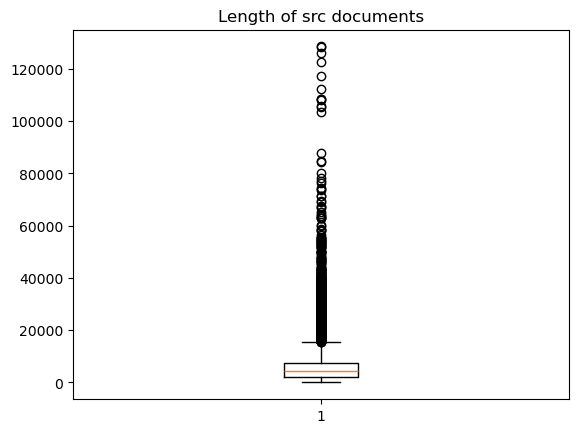

Median 4323.0
Mean 6177.204738015607
Max 128566
Min 6
90-percentile 12767.700000000003


In [14]:
plt.boxplot(src_lens)
plt.title("Length of src documents")
plt.show()
print("Median", np.median(src_lens))
print("Mean",np.mean(src_lens))
print("Max",np.max(src_lens))
print("Min",np.min(src_lens))
n=90
print(f"{n}-percentile",np.percentile(src_lens,n))

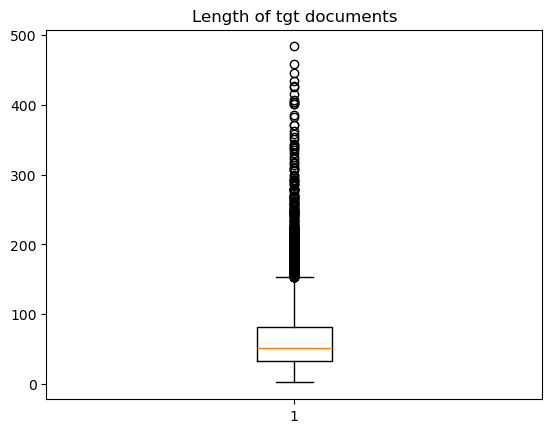

Median 52.0
Mean 62.63952062430323
Max 484
Min 2
90-percentile 116.0


In [15]:
plt.boxplot(tgt_lens)
plt.title("Length of tgt documents")
plt.show()
print("Median", np.median(tgt_lens))
print("Mean",np.mean(tgt_lens))
print("Max",np.max(tgt_lens))
print("Min",np.min(tgt_lens))
n=90
print(f"{n}-percentile",np.percentile(tgt_lens,n))

In [35]:
from transformers import AutoTokenizer
from nltk import sent_tokenize
old_tokenizer = AutoTokenizer.from_pretrained("allenai/PRIMERA")

In [36]:
def get_training_corpus(data):
    return [data[i:i+100]["text"] for i in range(0,data.shape[0],100)]

In [37]:
vocab=vocab_freq.keys()
training_corpus=get_training_corpus(train_df)
tokenizer=old_tokenizer.train_new_from_iterator(training_corpus,70000)

In [38]:
print("Vocab size,", len(tokenizer.vocab))

Vocab size, 70000


In [42]:
tokenizer.pad_token_id

1

In [44]:
tokenizer.save_pretrained("./primera-tokenizer")

('./primera-tokenizer\\tokenizer_config.json',
 './primera-tokenizer\\special_tokens_map.json',
 './primera-tokenizer\\vocab.json',
 './primera-tokenizer\\merges.txt',
 './primera-tokenizer\\added_tokens.json',
 './primera-tokenizer\\tokenizer.json')

In [24]:
tokenizer.pad_token_id

1

In [45]:
text=train_df.loc[0].text
ids=tokenizer.encode(text)
print(ids)
decoded_text=tokenizer.decode(ids)
decoded_text

Token indices sequence length is longer than the specified maximum sequence length for this model (5420 > 4096). Running this sequence through the model will result in indexing errors


[0, 17025, 13340, 7822, 282, 1562, 38553, 26079, 285, 10458, 43510, 2984, 29044, 13340, 18, 41064, 42925, 29044, 25338, 27926, 11028, 13873, 342, 9463, 14641, 8499, 19, 2178, 3702, 285, 2764, 1698, 6628, 20419, 6983, 2981, 301, 1673, 18, 29324, 304, 18903, 9467, 278, 283, 451, 342, 2209, 3319, 2361, 301, 22052, 304, 281, 283, 2503, 1157, 282, 16858, 2009, 285, 2764, 1673, 18, 29324, 820, 2720, 878, 2519, 6642, 288, 9390, 281, 314, 604, 283, 2519, 895, 285, 2608, 31496, 6983, 2221, 18, 8337, 19293, 301, 328, 65049, 18, 29324, 304, 321, 2764, 1673, 18, 29324, 342, 283, 451, 285, 22052, 278, 279, 7907, 1417, 288, 1934, 593, 1484, 37627, 39323, 381, 301, 40925, 3919, 3175, 22052, 281, 15538, 340, 335, 282, 997, 999, 309, 1319, 6847, 18, 33525, 3114, 301, 17380, 361, 304, 459, 406, 19, 21, 5040, 7866, 2608, 1673, 18, 8337, 19293, 301, 1673, 18, 29324, 361, 304, 380, 406, 19, 21, 5040, 7866, 328, 65049, 18, 8337, 19293, 301, 328, 65049, 18, 29324, 361, 304, 3524, 12334, 5034, 2530, 288, 1303

'<s>Improved Cell Survival and Paracrine Capacity of Human Embryonic Stem Cell-Derived Mesenchymal Stem Cells Promote Therapeutic Potential for Pulmonary Arterial Hypertension. Although transplantation of adult bone marrow mesenchymal stem cells ( BM-MSCs ) holds promise in the treatment for pulmonary arterial hypertension ( PAH ) , the poor survival and differentiation potential of adult BM-MSCs have limited their therapeutic efficiency . Here , we compared the therapeutic efficacy of human embryonic stem cell-derived MSCs ( hESC-MSCs ) with adult BM-MSCs for the treatment of PAH in an animal model . One week following monocrotaline (MCT)-induced PAH , mice were r and omly assigned to receive phosphate-buffered saline ( MCT group ) ; 3.0 × 106 human BM-derived MSCs ( BM-MSCs group ) or 3.0 × 106 hESC-derived MSCs ( hESC-MSCs group ) via tail vein injection . At 3 weeks posttransplantation , the right ventricular systolic pressure ( RVSP ) , degree of RV hypertrophy , and medial wall t